In [1]:
from commonfunctions import *
import numpy as np
import skimage
import skimage.io as io
import matplotlib.pyplot as plt
from skimage import filters, feature
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, binary_opening, skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
import cv2 as cv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\ProgramData\anaconda3\Lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


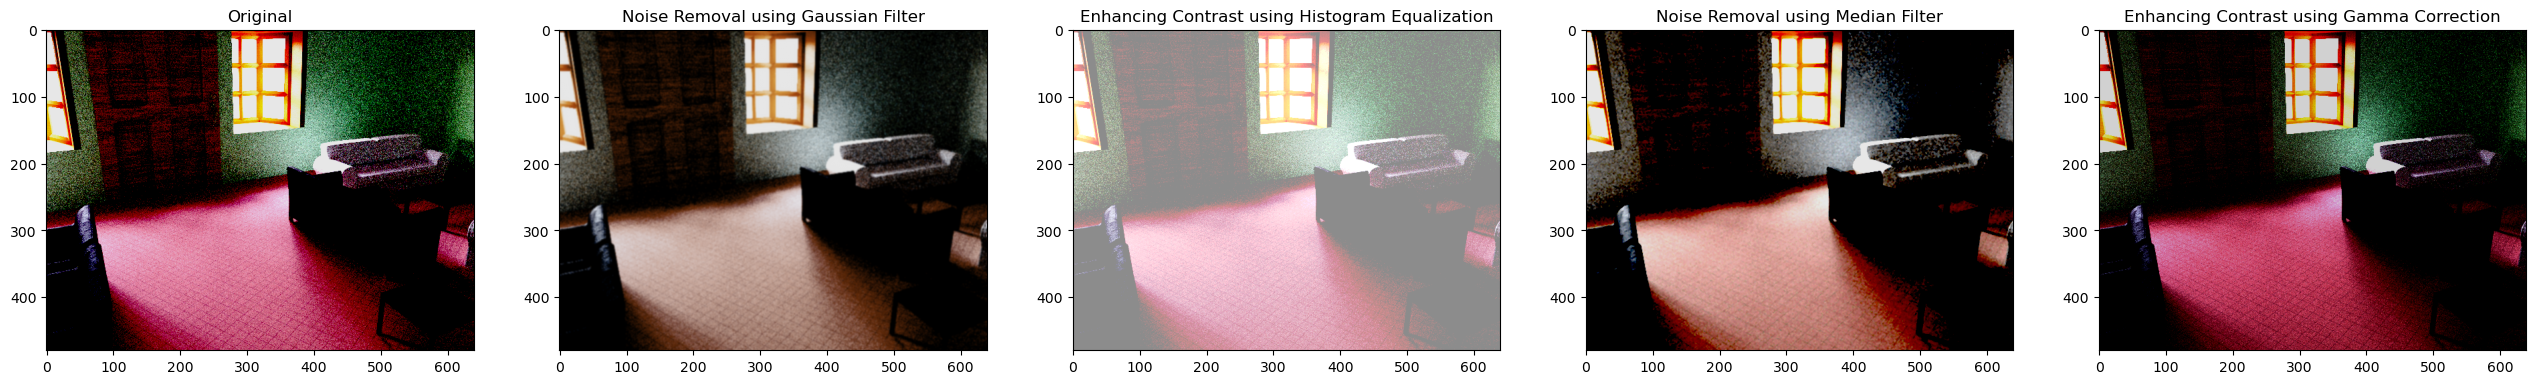

In [2]:
q1 = io.imread('./Q1.png')[:, :, :3]

q1_gaussian = skimage.filters.gaussian(q1)
q1_equ = skimage.exposure.equalize_hist(q1)
q1_median = skimage.filters.median(q1)
q1_gamma = skimage.exposure.adjust_gamma(q1, gamma=2)
# show_images([q1_gaussian], ['Gaussian Filter'])

show_images([q1, q1_gaussian, q1_equ, q1_median, q1_gamma], ['Original', 'Noise Removal using Gaussian Filter', 'Enhancing Contrast using Histogram Equalization', 'Noise Removal using Median Filter', 'Enhancing Contrast using Gamma Correction'])

[ 22   0 254 287]


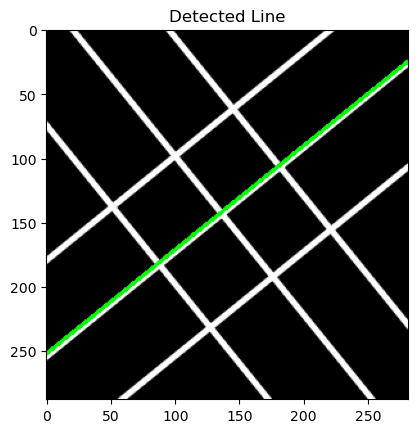

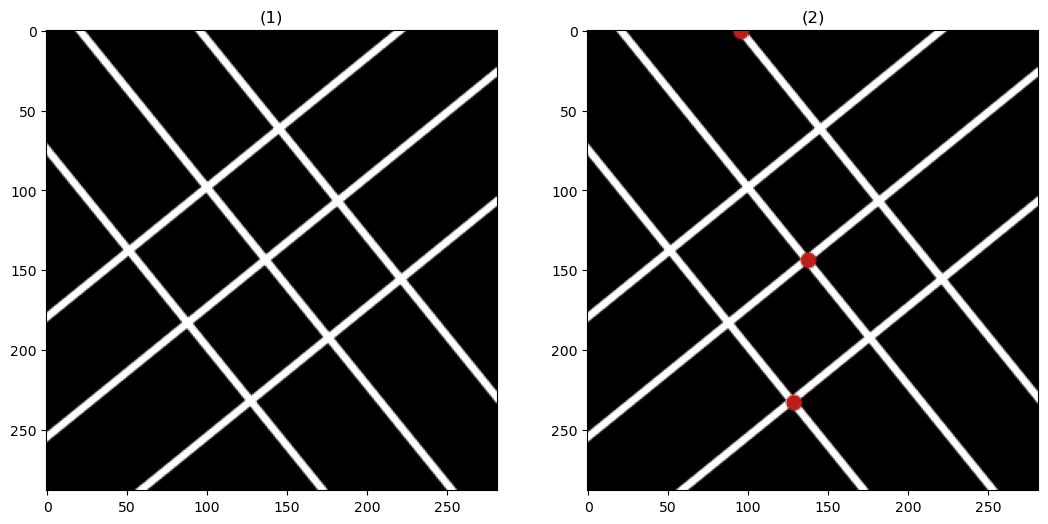

In [ ]:
q2 = io.imread('./Q2.png')[:, :, :3]
q2_exp = io.imread('./Q2-Explain.png')[:, :, :3]

q2_gray = rgb2gray(q2)

lines = cv.HoughLinesP((q2_gray * 255).astype(np.uint8), 1, np.pi / 180, 100, minLineLength=50, maxLineGap=10) # TODO: Understand the parameters

print(lines[0][0])
# lines 1 & 3 for point 2
x1, y1, x2, y2 = lines[5][0]
q2_lines = q2.copy()
cv.line(q2_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)
show_images([q2_lines], ['Detected Line'])

show_images([q2, q2_exp])

"""
This code snippet is performing the following actions:

print(lines[0][0]): This line prints the first element of the first line in the lines list. The lines list likely contains coordinates of detected lines.

x1, y1, x2, y2 = lines[5][0]: This line extracts the coordinates of the endpoints of the sixth line in the lines list. The coordinates are unpacked into variables x1, y1, x2, and y2.

q2_lines = q2.copy(): This line creates a copy of the q2 image, storing it in the variable q2_lines.

cv.line(q2_lines, (x1, y1), (x2, y2), (0, 255, 0), 2): This line draws a green line (color (0, 255, 0)) with a thickness of 2 pixels on the q2_lines image from point (x1, y1) to point (x2, y2) using OpenCV's cv.line function.

show_images([q2_lines], ['Detected Line']): This line displays the q2_lines image with the title 'Detected Line'. The show_images function is likely a custom function for displaying images.
"""

[(54, 139), (88, 182), (103, 98), (129, 233), (138, 142), (145, 65), (179, 192), (180, 108), (220, 158)]
[(145, 65), (103, 98), (180, 108), (54, 139), (138, 142), (220, 158), (88, 182), (179, 192), (129, 233)]


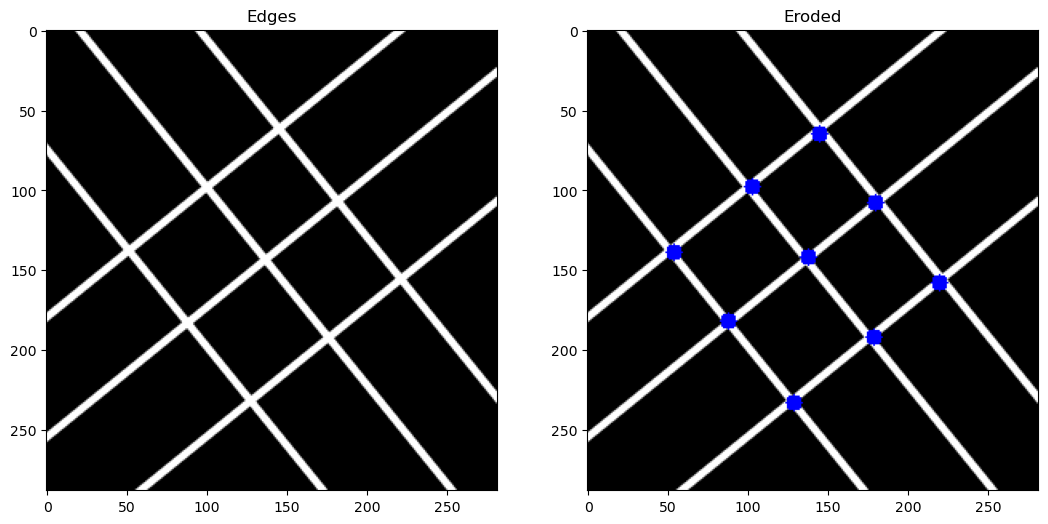

In [4]:
def clean_lines(lines): # Remove duplicate lines (lines that are very close to each other) and return the clean lines list
    clean_lines = []

    for i in range(len(lines)):
        check = True
        for j in range(i + 1, len(lines)):
            x1, y1, x2, y2 = lines[i][0]
            x3, y3, x4, y4 = lines[j][0]

            m1 = (y2 - y1) / (x2 - x1)
            m2 = (y4 - y3) / (x4 - x3)

            c1 = y1 - m1 * x1
            c2 = y3 - m2 * x3
            # if the slope and the y-intercept of the two lines are very close to each other, then they are considered the same line and one of them should be removed
            if abs(m1 - m2) < 0.1 and abs(c1 - c2) < 10: 
                check = False
                break
        if check:
            clean_lines.append(lines[i])
    return clean_lines

def find_intersections(lines, img_shape): # Return a list of intersection points (x, y) of the lines in the image 
    intersections = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            x1, y1, x2, y2 = lines[i][0]
            x3, y3, x4, y4 = lines[j][0]

            denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if denominator == 0:
                continue

            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

            if 0 <= px < img_shape[1] and 0 <= py < img_shape[0]:
                intersections.append((int(px), int(py)))
    return intersections

image = cv.imread('./Q2.png', cv.IMREAD_GRAYSCALE)

lines = cv.HoughLinesP(image, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=5)
lines = clean_lines(lines)

intersections = find_intersections(lines, image.shape)
intersections.sort(key=lambda x: x[0])
print(intersections)
intersections.sort(key=lambda x: x[1])
print(intersections)


result_image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
# for line in lines:
#     x1, y1, x2, y2 = line[0]
#     cv.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 1)

for px, py in intersections:
    cv.circle(result_image, (px, py), 5, (0, 0, 255), -1)

show_images([image, result_image], ['Edges', 'Eroded', 'Detected Lines and Intersections'])


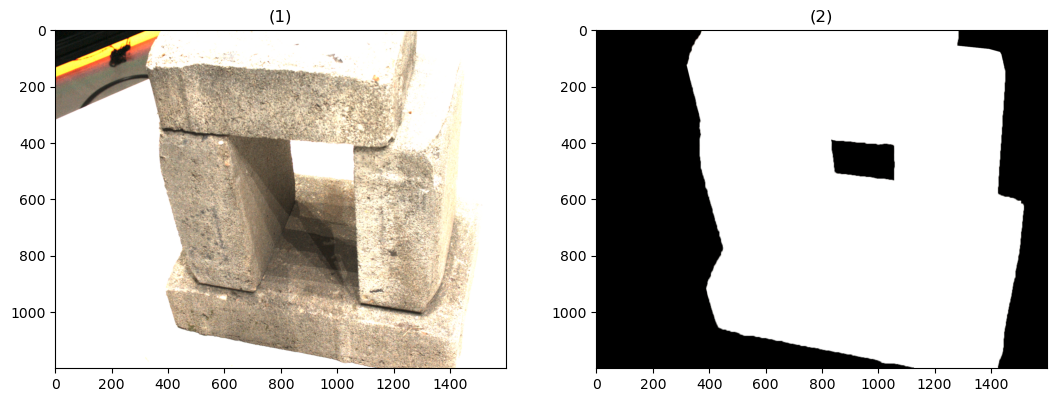

In [5]:
q3 = io.imread('./Q3.png')[:, :, :3]
q3_exp = io.imread('./Q3-Explain.png')[:, :, :3]
q3_eq = skimage.exposure.equalize_hist(q3)
show_images([q3, q3_exp])

[[129.07114114 129.07254383 129.07562738 ... 127.39309243 127.39309243
  127.39309243]
 [129.07445021 129.07159823 129.07806804 ... 127.39309243 127.39309243
  127.39309243]
 [129.07937028 129.07264315 129.07886132 ... 127.39309243 127.39309243
  127.39309243]
 ...
 [127.39309243 127.39309243 127.39309243 ... 127.39309243 127.39309243
  127.39309243]
 [127.39309243 127.39309243 127.39309243 ... 127.39309243 127.39309243
  127.39309243]
 [127.39309243 127.39309243 127.39309243 ... 127.39309243 127.39309243
  127.39309243]]


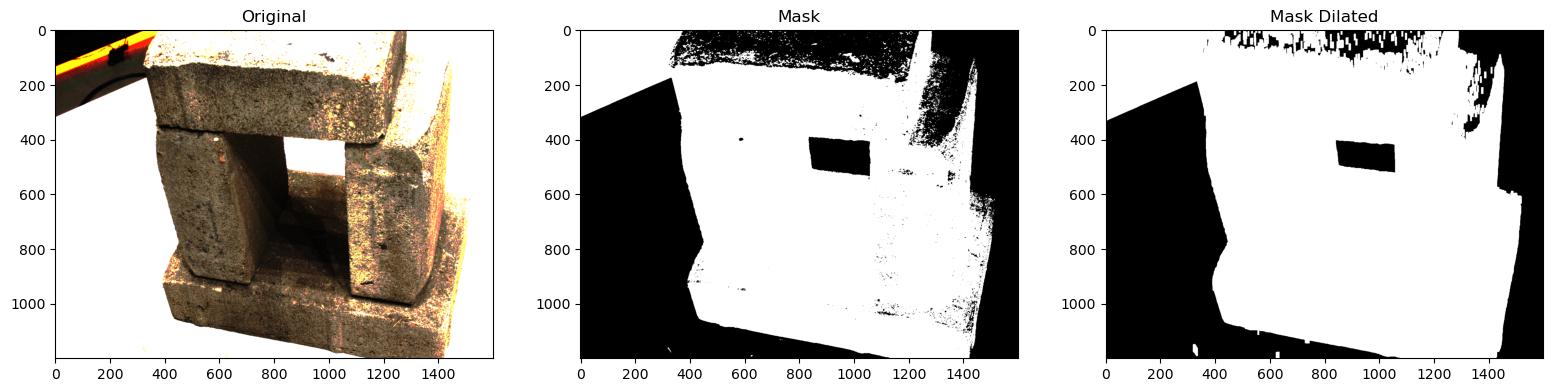

In [6]:
color = [89, 79, 50]

R = q3_eq[:, :, 0]
G = q3_eq[:, :, 1]
B = q3_eq[:, :, 2]

diff_R = R - color[0]
diff_G = G - color[1]
diff_B = B - color[2]

dist = np.sqrt(diff_R**2 + diff_G**2 + diff_B**2)
print(dist)
mask = dist >  127.4

mask_dilated = binary_dilation(mask, np.ones((25, 7)))

show_images([q3_eq, mask, mask_dilated], ['Original', 'Mask', 'Mask Dilated'])


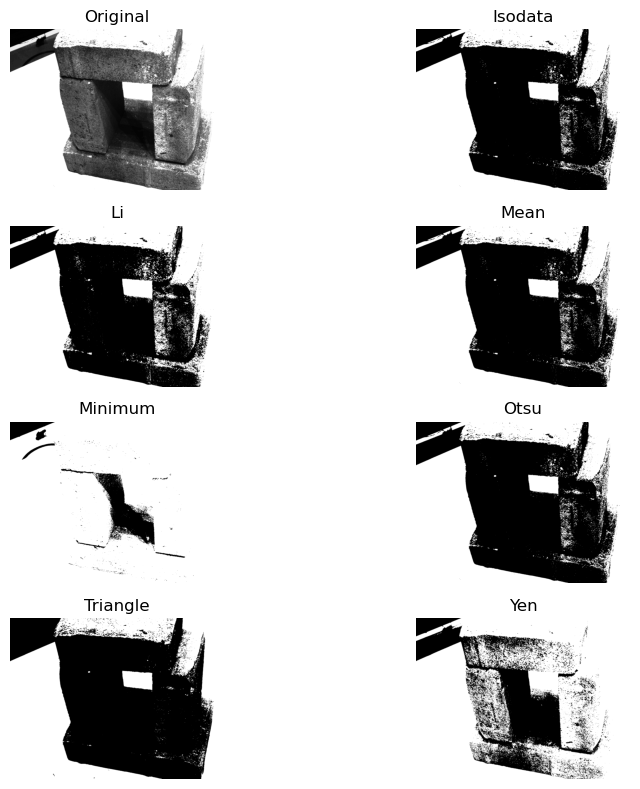

In [7]:
q3_gray = rgb2gray(q3_eq)
skimage.filters.try_all_threshold(q3_gray, figsize=(10, 8), verbose=False)
plt.show()

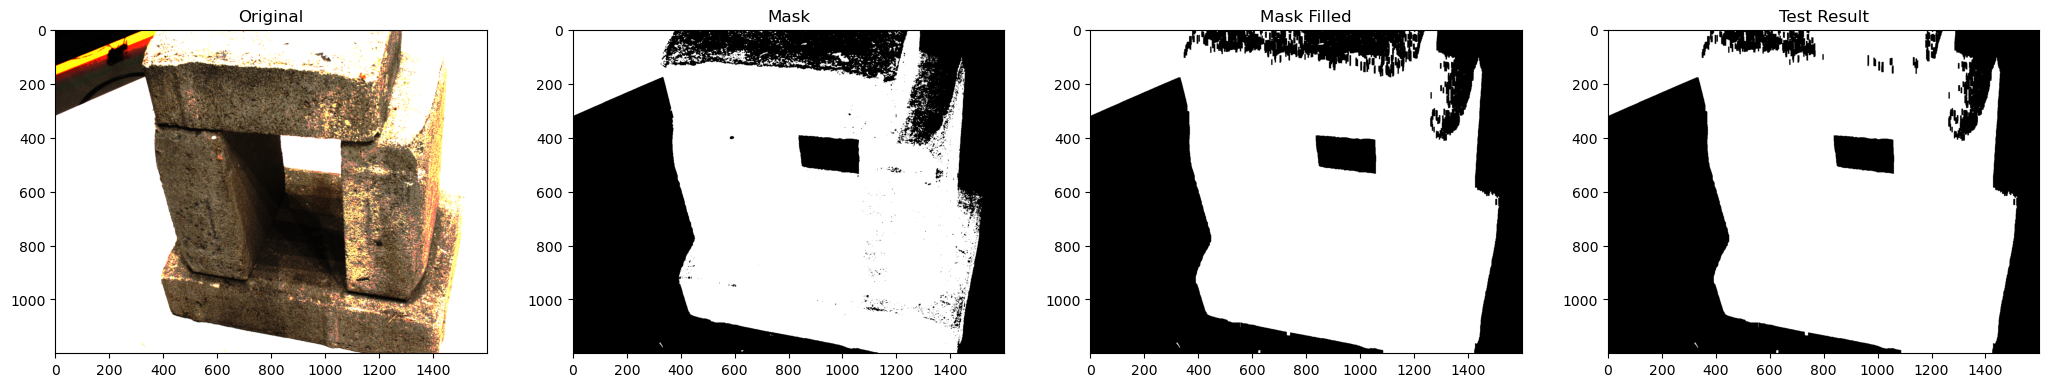

In [8]:
thresholded = skimage.filters.threshold_triangle(q3_gray)
mask = q3_gray < thresholded
mask_filled = binary_closing(mask, np.ones((21, 5)))

test = np.zeros(q3_gray.shape)
test[10][800] = 1
test[25][900] = 1
test[100][700] = 1
new_test = binary_dilation(test, np.ones((25, 7)))
# while np.equal(new_test, test).all() == False:
#     test = new_test
#     new_test = binary_dilation(test, np.ones((25, 7)))
#     new_test = new_test & (~mask_filled)
se = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])

for i in range(1500):
    test = binary_dilation(test, se)
    test = test & (~mask_filled)

show_images([q3_eq, mask, mask_filled, (test | mask_filled)], ['Original', 'Mask', 'Mask Filled', 'Test Result'])

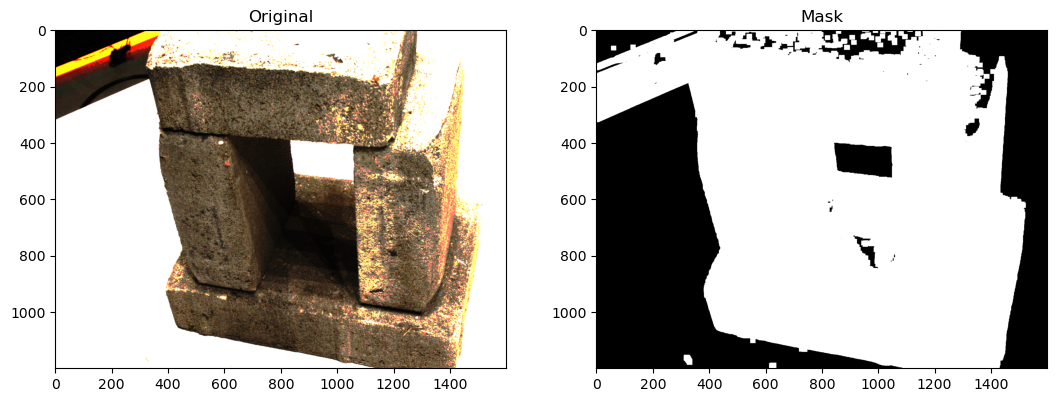

In [9]:
thresholded = skimage.filters.threshold_local(q3_gray, 5, offset=0.0045)
mask = q3_gray < thresholded
mask = binary_dilation(mask, np.ones((17, 19)))
show_images([q3_eq, mask], ['Original', 'Mask'])

[0, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 2

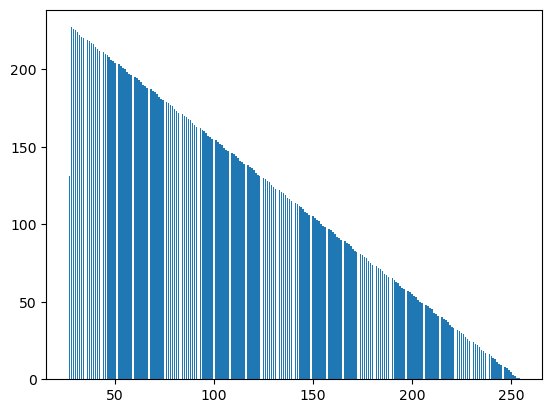

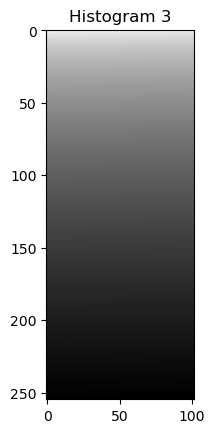

In [ ]:
'''
Create a grayscale image for each of the following plot as pixel intensity histogram:
-	Linear line ( x: [0, 255], y: [255, 0] ).

'''
import commonfunctions as cf


hist1 = np.zeros((200, 200), np.uint8)
hist1[:, :50] = 0
hist1[:, 50:150] = 100
hist1[:, 150:] = 200

# show_images([hist1], ['Histogram 1'])


#b)	Linear line ( x: [0,255], y: [0,255] ) [hint: try creating an image of size 255x102]
# 0.5 255 rows   255 col
hist2 = np.zeros((127, 255), np.uint8)
c1=0 #row
c2=0    #col
for i in range(255):
    for j in range(i):
        hist2[c1%127][c2]=i
        c2+=1
        if c2==255:
            c1+=1
            c2=0
hist2=255-hist2
    
# cf.showHist(hist2)
# show_images([hist2], ['Histogram 2'])
'''
-	Sine wave ( x: [0, 255], y: sin(x) ).
'''

img = np.zeros((255, 102))
V = [0]
for i in range(1, 255):
    for j in range(i):
        V.append(i)
count = 0
for i in range(255):
     for j in range(102): 
        img[i][j] = V[count] 
        count += 1
# print(V)
img=255-img
show_images([img], ['Histogram 3'])
# print(count)
# print(len(V))
showHist(img)
